# Выпускной проект

## Введение

### Цель работы

Уменьшить потребление электроэнергии на этапе обработки стали в  металлургическом комбинате.

### Задачи

1. Провести анализ данных, полученных из разных источников.

Для выполнения указанной задачи применяются стандартные библиотеки Python, проводится ознакомительный анализ, строятся и анализируются графики распределения значений разных параметров.

2. Сведение нескольких таблиц в единую по ключу, исключая ключи, оброшенные на этапе удаления пропуска данных.

Довольно простая задача, осуществляется одной функций.

3. Подготовка пайплайна.

Важно предусмотреть разделение выборок на тестовую и тренировочную 0,25/0,75 соответственно, масштабирование данных для использования линейной регрессии, а также Гридсерч, либо Рандомайзед серч. В целом, учитывая малое число наблюдений, можно будет прибегнуть к гридсерчу. По моделям планирую использовать линейную регрессию, lightgbm, catboost.

4. Определение наиболее эффективной модели.

И дальнейшее тестирование модели на тестовой выборке. Значение MАE должно быть ниже 6.8.

5. Подготовка отчета и формирование итогового вывода.

## Знакомство с данными

In [1]:
#!pip install phik 

In [2]:
#!pip install imblearn

In [3]:
#!pip install feature-engine

In [4]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from phik.report import correlation_report, plot_correlation_matrix

from sklearn import set_config
from sklearn.feature_selection import mutual_info_regression, SelectKBest
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error

from imblearn.pipeline import make_pipeline
from feature_engine.selection import DropDuplicateFeatures

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [5]:
sns.set(rc={'figure.figsize': (15, 7)})
set_config(display="diagram")
warnings.filterwarnings('ignore')

In [6]:
RS = 270323

### Данные температуры

In [7]:
try:
    temp = pd.read_csv('.../final_steel/data_temp.csv')
except:
    temp = pd.read_csv('/datasets/final_steel/data_temp.csv')

In [8]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [9]:
temp

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


In [10]:
temp.key.value_counts().describe()

count    3216.000000
mean        4.946206
std         1.793169
min         1.000000
25%         4.000000
50%         5.000000
75%         6.000000
max        16.000000
Name: key, dtype: float64

In [11]:
len(temp[temp.Температура.isna()].key.unique()) #смотрю количетсво пропусков по партиям, исключая дублирование

739

В изначальной таблице данные представлены данный по замерам температуры в каждом цикле каждой партии. Всего имеется 3216 партий. Самое большое количество циклов нагрева+легирования - 16, явно есть повод для оптимизиации. В среднем и в медиане - 5 циклов, также не очень мало, стоит стараться уменьшать число.

Для модели необходима первичная температура сплава, как один из признаков для обучения модели, а финальная тепература будет целевым признаком модели. Выделю эти данные в отдельную таблицу.

In [12]:
temp_data = pd.DataFrame(columns=['key', 'start_temp', 'target_temp'])

In [13]:
temp_data.key = temp.fillna(0).groupby(by='key', as_index=False).first().key
temp_data.target_temp = temp.fillna(0).groupby(by='key', as_index=False).last().Температура
temp_data.start_temp = temp.fillna(0).groupby(by='key', as_index=False).first().Температура

In [14]:
temp_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3216 entries, 0 to 3215
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          3216 non-null   int64  
 1   start_temp   3216 non-null   float64
 2   target_temp  3216 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 75.5 KB


In [15]:
temp_data

,key,start_temp,target_temp
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0
...,...,...,...
3211,3237,1569.0,0.0
3212,3238,1584.0,0.0
3213,3239,1598.0,0.0
3214,3240,1617.0,0.0


In [16]:
temp_data.describe().T

,count,mean,std,min,25%,50%,75%,max
key,3216.0,1622.199316,935.088523,1.0,815.75,1622.5,2431.25,3241.0
start_temp,3216.0,1588.592040,29.137454,1191.0,1572.00,1588.0,1606.00,1684.0
target_temp,3216.0,1228.744714,671.403549,0.0,1574.00,1590.0,1597.00,1700.0


In [17]:
print(len(temp_data))
print(len(temp_data.query('target_temp == 0')))
print(len(temp_data.query('start_temp < 1500')))
print(len(temp_data.query('target_temp < 1500 and target_temp != 0')))

3216
739
5
0


In [18]:
temp_data = temp_data.query('start_temp > 1500 and target_temp > 1500')
print(len(temp_data))
print(len(temp_data.query('target_temp == 0')))
print(len(temp_data.query('start_temp < 1500')))
print(len(temp_data.query('target_temp < 1500 and target_temp != 0')))

2473
0
0
0


In [19]:
temp_data

,key,start_temp,target_temp
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0
...,...,...,...
2472,2495,1570.0,1591.0
2473,2496,1554.0,1591.0
2474,2497,1571.0,1589.0
2475,2498,1591.0,1594.0


In [20]:
temp_data.describe().T

,count,mean,std,min,25%,50%,75%,max
key,2473.0,1249.664375,720.395663,1.0,627.0,1251.0,1872.0,2499.0
start_temp,2473.0,1589.016175,24.996127,1519.0,1572.0,1588.0,1605.0,1679.0
target_temp,2473.0,1595.338051,16.031388,1541.0,1587.0,1593.0,1599.0,1700.0


Итак, есть сводная таблица, партии теперь в уникальном значении, по каждой партии есть стартовая и целевая температуры. Удалены партии где были пропуски целевой температуры (739 наблюдей, 23% от всех данных, весомый объем, но без таргета никак), а также удалены партии где стартовая температура была ниже 1500 градусов (5 наблюдений).

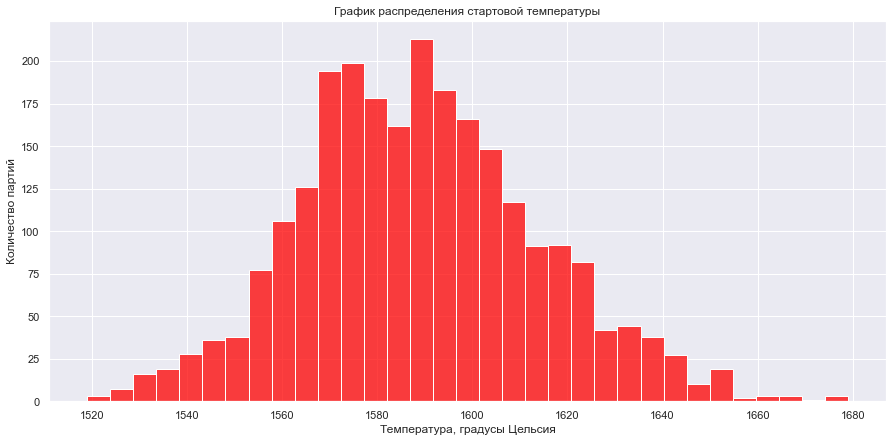

In [21]:
sns.histplot(temp_data.start_temp, color='red')
plt.title('График распределения стартовой температуры')
plt.xlabel('Температура, градусы Цельсия')
plt.ylabel('Количество партий');

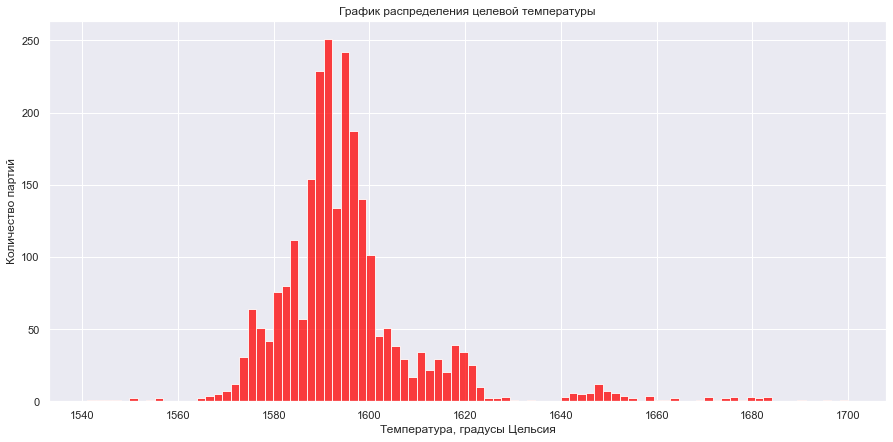

In [22]:
sns.histplot(temp_data.target_temp, color='red')
plt.title('График распределения целевой температуры')
plt.xlabel('Температура, градусы Цельсия')
plt.ylabel('Количество партий');

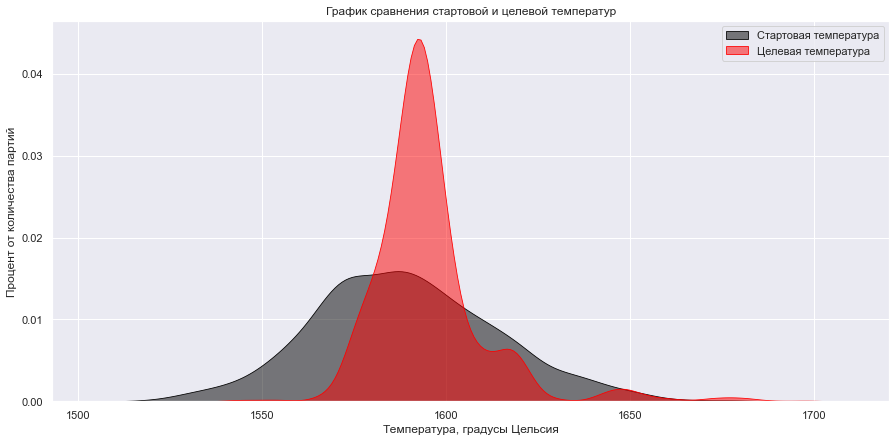

In [23]:
sns.kdeplot(
    temp_data.start_temp,
    fill=True,
    alpha=.5,
    linewidth=.8,
    color='black',
)

sns.kdeplot(
    temp_data.target_temp,
    fill=True,
    alpha=.5,
    linewidth=.8,
    color='red',
)
plt.legend(labels=['Стартовая температура', 'Целевая температура'])
plt.title(
    'График сравнения стартовой и целевой температур'
)
plt.xlabel('Температура, градусы Цельсия')
plt.ylabel('Процент от количества партий');

По графикам видно, что распределение температур стандартное, что ожидаемо и логично. При этом важно отметить, что разброс целевой температуры сильно уже, чем у стартовой. Данный факт позволяет сделать предположение о том, что дамми модель предсказания целевой температуры будет иметь довольно низкий уровень ошибки.

In [24]:
dumm = [temp_data.target_temp.median()] * len(temp_data.target_temp)

In [25]:
(abs(temp_data.target_temp - dumm)).mean()

9.906995551961181

Действительно, МАЕ предсказателя по медиане оказался ниже 10 градусов.

### Данные с электродов

In [26]:
try:
    arc = pd.read_csv('.../final_steel/data_arc.csv')
except:
    arc = pd.read_csv('/datasets/final_steel/data_arc.csv')

In [27]:
arc.columns = ['key', 'start', 'end', 'act', 'react']

In [28]:
arc['time'] = (pd.to_datetime(arc['end']) - pd.to_datetime(arc['start']))

In [29]:
arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype          
---  ------  --------------  -----          
 0   key     14876 non-null  int64          
 1   start   14876 non-null  object         
 2   end     14876 non-null  object         
 3   act     14876 non-null  float64        
 4   react   14876 non-null  float64        
 5   time    14876 non-null  timedelta64[ns]
dtypes: float64(2), int64(1), object(2), timedelta64[ns](1)
memory usage: 697.4+ KB


In [30]:
arc.time = list(map(lambda x: x.seconds, arc.time))

In [31]:
arc.describe().T

,count,mean,std,min,25%,50%,75%,max
key,14876.0,1615.220422,934.571502,1.000000,806.000000,1617.000000,2429.000000,3241.000000
act,14876.0,0.670441,0.408159,0.030002,0.395297,0.555517,0.857034,3.731596
react,14876.0,0.452592,5.878702,-715.504924,0.290991,0.415962,0.637371,2.676388
time,14876.0,171.670946,98.186803,11.000000,107.000000,147.000000,214.000000,907.000000


In [32]:
arc

,key,start,end,act,react,time
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148
...,...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439,157
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631,180
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654,184
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768,57


Данные по электродам представлены в формате таблицы по температуре, необходимо свести их в таблицу с привязкой к номеру партии. Буду сохранять показатели первичного нагрева, время первичного нагрева в секундах, суммарное время нагревов, аггрегирую мощности по партии, создам несколько синтетических признаков (отношения мощностей и отношение мощности ко времени) на моменте анализа корреляции решу какие признаки выбросить. Выброшу данные где отрицательная мощность.

In [33]:
arc = arc.query('react > 0')

In [34]:
arc_data = pd.DataFrame(columns=['key', 'act', 'react', 'act_mean', 'react_mean', 'time', 'sum_time', 'mean_time', 'act_l', 'react_l'])

In [35]:
arc_data['key'] = arc.groupby(by='key', as_index=False).first().key
arc_data['act'] = arc.groupby(by='key', as_index=False).first().act
arc_data['react'] = arc.groupby(by='key', as_index=False).first().react
arc_data['act_mean'] = arc.groupby(by='key', as_index=False).mean().act
arc_data['react_mean'] = arc.groupby(by='key', as_index=False).mean().react
arc_data['time'] = arc.groupby(by='key', as_index=False).first().time
arc_data['sum_time'] = arc.groupby(by='key', as_index=False).sum().time
arc_data['mean_time'] = arc.groupby(by='key', as_index=False).mean().time
arc_data['act_l'] = arc.groupby(by='key', as_index=False).last().act
arc_data['react_l'] = arc.groupby(by='key', as_index=False).last().react

In [36]:
arc_data['act_time'] = arc_data['act_mean'] / arc_data['mean_time']
arc_data['act_react'] = arc_data['act_mean'] / arc_data['react_mean']

In [37]:
arc_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         3214 non-null   int64  
 1   act         3214 non-null   float64
 2   react       3214 non-null   float64
 3   act_mean    3214 non-null   float64
 4   react_mean  3214 non-null   float64
 5   time        3214 non-null   int64  
 6   sum_time    3214 non-null   int64  
 7   mean_time   3214 non-null   float64
 8   act_l       3214 non-null   float64
 9   react_l     3214 non-null   float64
 10  act_time    3214 non-null   float64
 11  act_react   3214 non-null   float64
dtypes: float64(9), int64(3)
memory usage: 301.4 KB


In [38]:
arc_data

,key,act,react,act_mean,react_mean,time,sum_time,mean_time,act_l,react_l,act_time,act_react
0,1,0.976059,0.687084,0.975629,0.636648,228,1098,219.60,0.692755,0.414397,0.004443,1.532447
1,2,0.438063,0.283043,0.763150,0.499528,137,811,202.75,0.827743,0.516874,0.003764,1.527741
2,3,1.062053,0.671494,0.505176,0.319815,280,655,131.00,0.250280,0.155901,0.003856,1.579589
3,4,0.875313,0.614404,0.802313,0.515074,207,741,185.25,1.220955,0.754719,0.004331,1.557663
4,5,0.950026,0.690523,0.836793,0.563161,251,869,217.25,0.267457,0.181992,0.003852,1.485887
...,...,...,...,...,...,...,...,...,...,...,...,...
3209,3237,0.405685,0.320431,0.786493,0.565692,119,909,181.80,0.606049,0.419084,0.004326,1.390321
3210,3238,0.371511,0.309811,0.702176,0.560394,111,546,182.00,0.717559,0.520623,0.003858,1.253004
3211,3239,0.512136,0.403724,0.583344,0.388952,147,1216,152.00,0.488352,0.317727,0.003838,1.499784
3212,3240,0.411601,0.274390,0.596817,0.496653,121,839,167.80,0.548882,0.416994,0.003557,1.201676


In [39]:
arc_data.describe().T

,count,mean,std,min,25%,50%,75%,max
key,3214.0,1623.061294,934.739859,1.000000,817.250000,1623.500000,2431.750000,3241.000000
act,3214.0,0.546554,0.258101,0.035165,0.415074,0.476037,0.581292,2.940772
react,3214.0,0.420565,0.204928,0.026222,0.313229,0.364772,0.451653,2.211983
act_mean,3214.0,0.671067,0.207490,0.186226,0.519691,0.646633,0.797201,1.819169
react_mean,3214.0,0.501532,0.153933,0.130062,0.387213,0.489478,0.599788,1.141721
time,3214.0,154.080274,63.617900,23.000000,122.000000,135.000000,168.000000,724.000000
sum_time,3214.0,794.545115,332.491076,57.000000,571.000000,770.000000,983.000000,4189.000000
mean_time,3214.0,172.339212,45.606776,57.000000,140.000000,168.750000,200.383333,380.000000
act_l,3214.0,0.490205,0.287018,0.030002,0.287390,0.420749,0.610934,2.909521
react_l,3214.0,0.353347,0.206060,0.021154,0.207593,0.304691,0.443483,1.797347


Данные готовы для дальнейшего анализа. Видно, что время нагрева, активная и реактивная мощности имеет небольшое смещение влево, думаю мы увидим его на графиках.

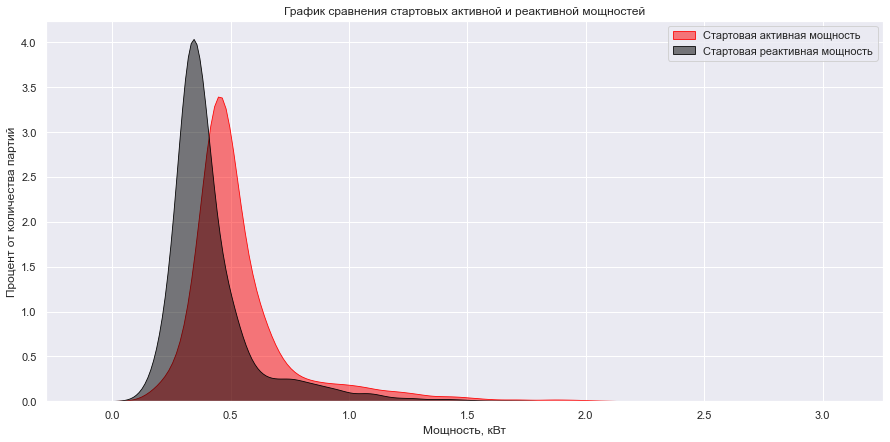

In [40]:
sns.kdeplot(
    arc_data.act,
    fill=True,
    alpha=.5,
    linewidth=.8,
    color='red',
)

sns.kdeplot(
    arc_data.react,
    fill=True,
    alpha=.5,
    linewidth=.8,
    color='black',
)
plt.legend(labels=['Стартовая активная мощность', 'Стартовая реактивная мощность'])
plt.title('График сравнения стартовых активной и реактивной мощностей')
plt.xlabel('Мощность, кВт')
plt.ylabel('Процент от количества партий');

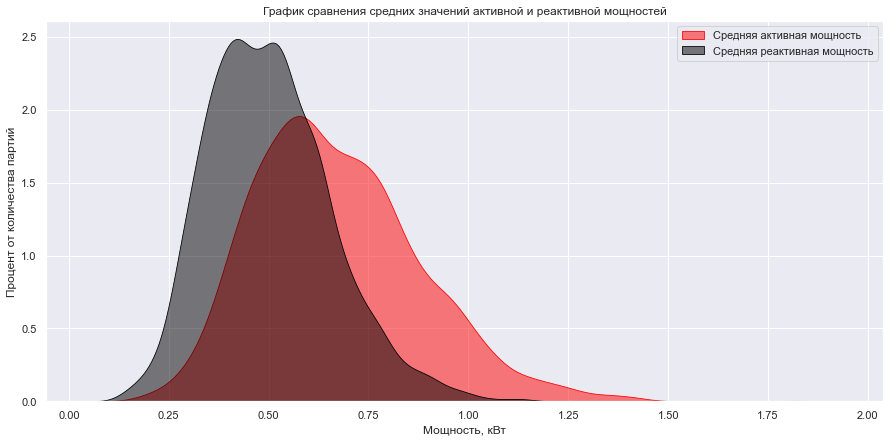

In [41]:
sns.kdeplot(
    arc_data.act_mean,
    fill=True,
    alpha=.5,
    linewidth=.8,
    color='red',
)

sns.kdeplot(
    arc_data.react_mean,
    fill=True,
    alpha=.5,
    linewidth=.8,
    color='black',
)

plt.legend(labels=['Средняя активная мощность', 'Средняя реактивная мощность'])
plt.title('График сравнения средних значений активной и реактивной мощностей')
plt.xlabel('Мощность, кВт')
plt.ylabel('Процент от количества партий');

Графики демонстрируют нормальное распределение со смещением влево. 

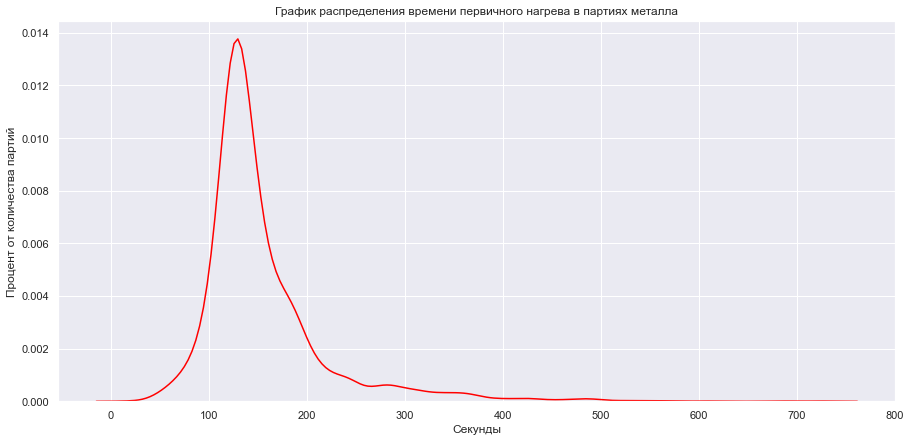

In [42]:
sns.distplot(arc_data.time, hist=False, color='red')
plt.title('График распределения времени первичного нагрева в партиях металла')
plt.xlabel('Секунды')
plt.ylabel('Процент от количества партий');

График демонстрируют нормальное распределение со смещением влево.

### BULK

In [43]:
try:
    bulk = pd.read_csv('.../final_steel/data_bulk.csv')
except:
    bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')

In [44]:
bulk

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0


In [45]:
bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [46]:
bulk.columns = [x.replace(' ', '_') for x in bulk.columns]
bulk.columns = [x.lower() for x in bulk.columns]

In [47]:
len(bulk[bulk.T.isna().sum() > 14]) # проверка на наличие партий без добавок

0

Данные по сыпучим материалам представлены сразу по партиям литья. Важно отметить, что партии литья без добавления сыпучих материалов отсутствуют, что не может не радовать.

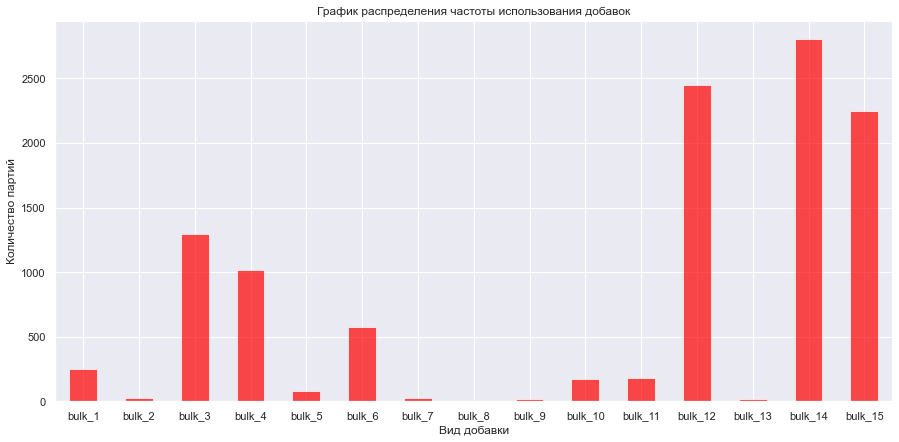

In [48]:
pd.DataFrame(bulk.count()).drop('key').plot(kind='bar', color='red', alpha=.7, rot=0).get_legend().remove()
plt.title('График распределения частоты использования добавок')
plt.xlabel('Вид добавки')
plt.ylabel('Количество партий');

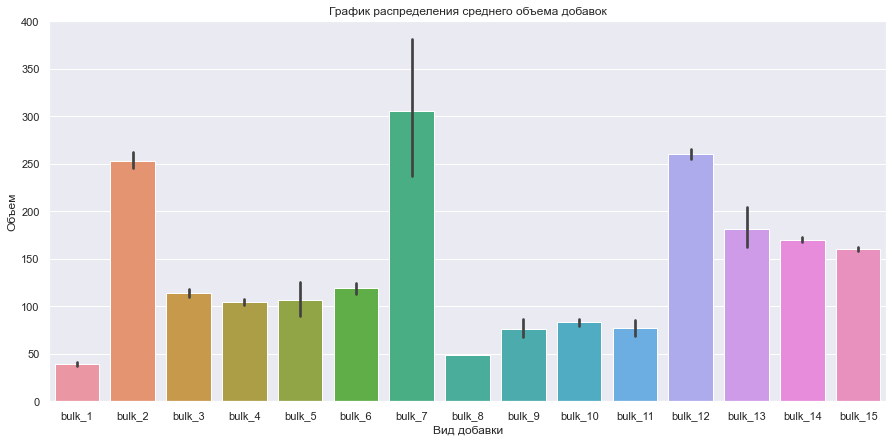

In [49]:
sns.barplot(data=pd.melt(bulk.drop('key', axis=1)), x="variable", y="value")
plt.title('График распределения среднего объема добавок')
plt.xlabel('Вид добавки')
plt.ylabel('Объем');

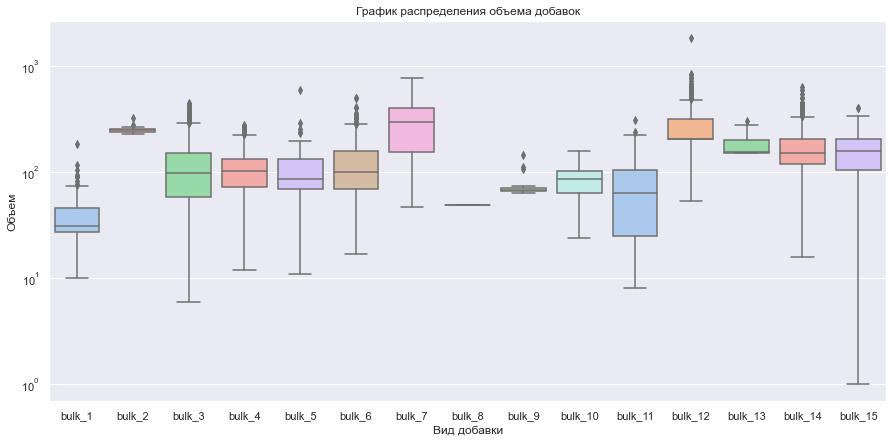

In [50]:
sns.boxplot(data=pd.melt(bulk.drop('key', axis=1)), x="variable", y="value", palette=('pastel'));
plt.yscale('log')
plt.title('График распределения объема добавок')
plt.xlabel('Вид добавки')
plt.ylabel('Объем');

Из графиков распределения видно, что в целом разброс объемов добавок не очень большой (за некоторыми исключениям), статистические выбросы встречаются, но не в большом количестве. В основном среднее значение колеблется от 100 до 300. Чаще всего используются добавки 14, 12 и 15.

### WIRE

In [51]:
try:
    wire = pd.read_csv('.../final_steel/data_wire.csv')
except:
    wire = pd.read_csv('/datasets/final_steel/data_wire.csv')

In [52]:
wire.columns = [x.replace(' ', '_') for x in wire.columns]
wire.columns = [x.lower() for x in wire.columns]

In [53]:
wire

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3055 non-null   float64
 2   wire_2  1079 non-null   float64
 3   wire_3  63 non-null     float64
 4   wire_4  14 non-null     float64
 5   wire_5  1 non-null      float64
 6   wire_6  73 non-null     float64
 7   wire_7  11 non-null     float64
 8   wire_8  19 non-null     float64
 9   wire_9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [55]:
len(wire[wire.T.isna().sum() > 8])

0

Ситуация полностью аналогична сыпучим добавкам, также проверил, что нет партий без добавления проволоки. Можно переходить к графикам.

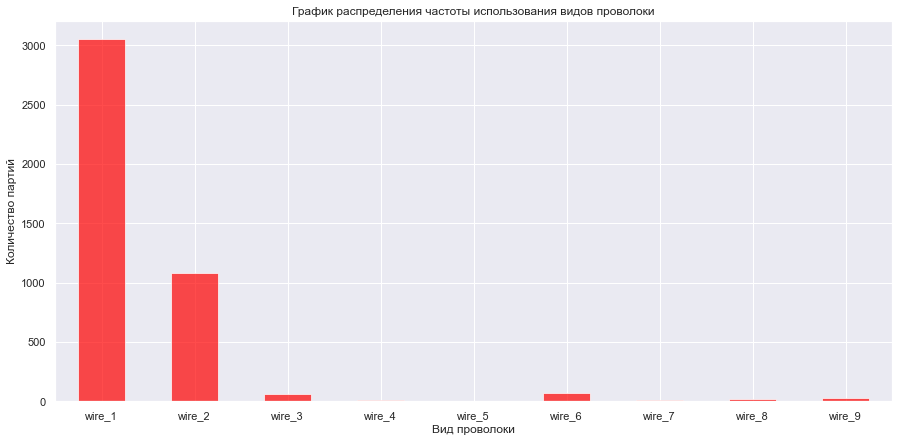

In [56]:
pd.DataFrame(wire.count()).drop('key').plot(kind='bar', color='red', alpha=.7, rot=0).get_legend().remove()
plt.title('График распределения частоты использования видов проволоки')
plt.xlabel('Вид проволоки')
plt.ylabel('Количество партий');

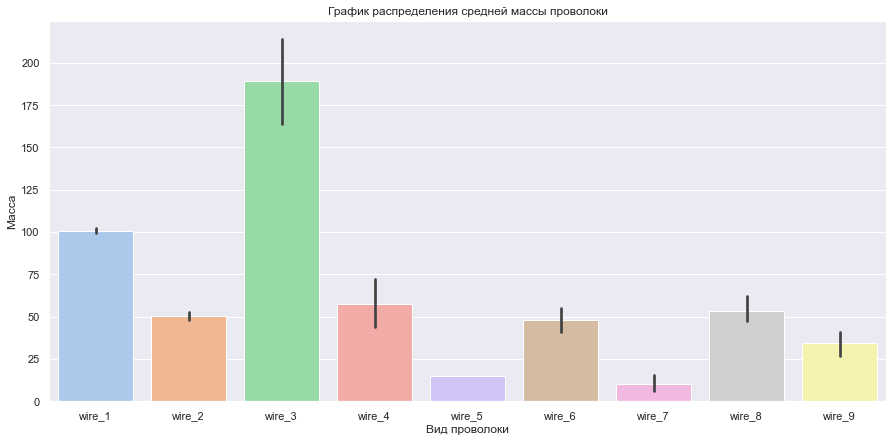

In [57]:
sns.barplot(data=pd.melt(wire.drop('key', axis=1)), x="variable", y="value", palette='pastel')
plt.title('График распределения средней массы проволоки')
plt.xlabel('Вид проволоки')
plt.ylabel('Масса');

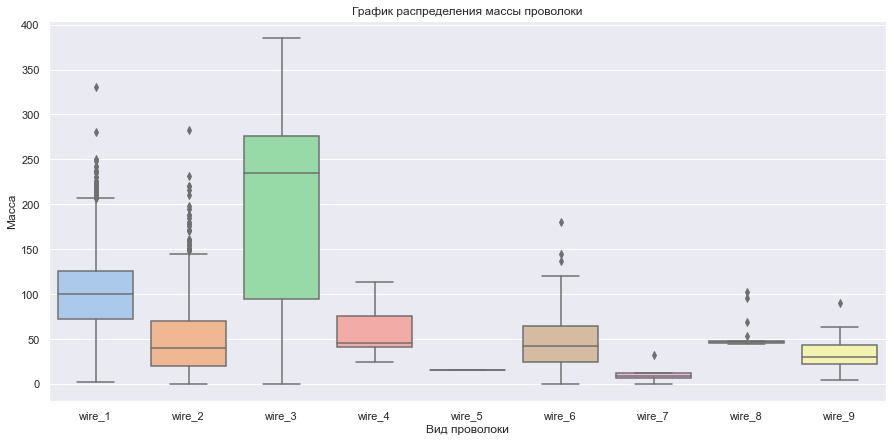

In [58]:
sns.boxplot(data=pd.melt(wire.drop('key', axis=1)), x="variable", y="value", palette=('pastel'))
plt.title('График распределения массы проволоки')
plt.xlabel('Вид проволоки')
plt.ylabel('Масса');

Из графиков видно, что чаще всего используются проволоки 1 и 2 типа, однако наибольшая масса при добавку у 3 типа.

### GAS

In [59]:
try:
    gas = pd.read_csv('.../final_steel/data_gas.csv')
except:
    gas = pd.read_csv('/datasets/final_steel/data_gas.csv')

In [60]:
gas.columns = ['key', 'gas']

In [61]:
gas

,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
...,...,...
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103


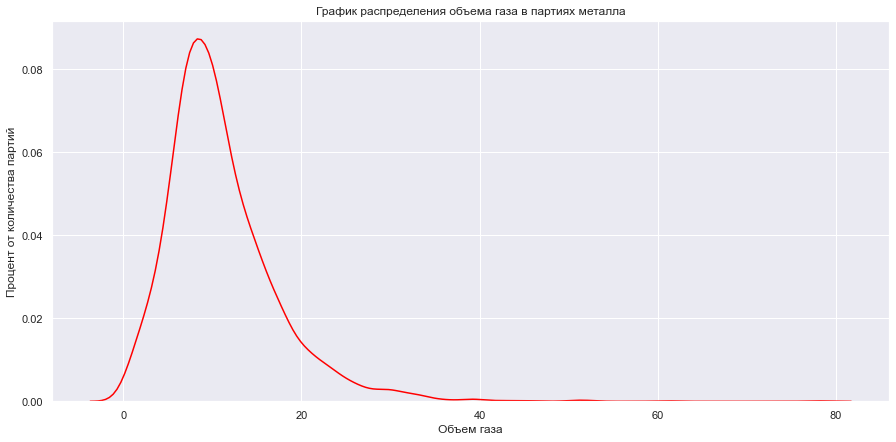

In [62]:
sns.distplot(gas.gas, hist=False, color='red')
plt.title('График распределения объема газа в партиях металла')
plt.xlabel('Объем газа')
plt.ylabel('Процент от количества партий');

С газом все просто. Нормальное распределение, которе смещено влево из-за наличия партий с большими объемами.

### Анализ времени

In [63]:
try:
    time_wire = pd.read_csv('.../final_steel/data_wire_time.csv')
except:
    time_wire = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

In [64]:
try:
    time_bulk = pd.read_csv('C:/Users/A/Desktop/final_steel/data_bulk_time.csv')
except:
    time_bulk = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')

In [65]:
time_wire

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,2019-08-31 22:50:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,2019-08-31 23:38:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,2019-09-01 01:50:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-01 03:12:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [66]:
time_bulk

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,2019-08-31 22:51:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 22:46:52,NaN,2019-08-31 22:46:52,2019-08-31 22:46:52
3125,3238,NaN,NaN,2019-08-31 23:39:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 23:33:09,NaN,2019-08-31 23:33:09,2019-08-31 23:33:09
3126,3239,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:51:58,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:39:41,NaN,2019-09-01 01:33:25,2019-09-01 01:33:25
3127,3240,NaN,NaN,NaN,NaN,NaN,2019-09-01 03:12:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01 02:41:27,2019-09-01 02:41:27


Указанные таблицы содержат сведения о времени закладки проволоки и сыпучих компонентов. В дальней работе их использовать не планирую.

### Сводная таблица

In [67]:
data = temp_data.merge(arc_data, on='key', how='inner')
data = data.merge(gas, on='key', how='inner')
data = data.merge(bulk, on='key', how='inner')
data = data.merge(wire, on='key', how='inner')

In [68]:
data

,key,start_temp,target_temp,act,react,act_mean,react_mean,time,sum_time,mean_time,...,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,1571.0,1613.0,0.976059,0.687084,0.975629,0.636648,228,1098,219.600000,...,154.0,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1581.0,1602.0,0.438063,0.283043,0.763150,0.499528,137,811,202.750000,...,154.0,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1596.0,1599.0,1.062053,0.671494,0.505176,0.319815,280,655,131.000000,...,153.0,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1601.0,1625.0,0.875313,0.614404,0.802313,0.515074,207,741,185.250000,...,154.0,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1576.0,1602.0,0.950026,0.690523,0.836793,0.563161,251,869,217.250000,...,152.0,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2320,2495,1570.0,1591.0,0.875021,0.705281,0.802673,0.590194,207,723,180.750000,...,223.0,89.150879,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2321,2496,1554.0,1591.0,0.393625,0.287355,0.700511,0.468364,117,940,156.666667,...,226.0,114.179527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2322,2497,1571.0,1589.0,0.580983,0.504512,0.737460,0.617090,156,569,189.666667,...,226.0,94.086723,9.04800,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2323,2498,1591.0,1594.0,1.162895,0.832519,0.681745,0.471086,256,750,150.000000,...,207.0,118.110717,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Все необходимые данные сведены в 1 общую таблицу. Можно проверить мультиколлениарность.

interval columns not set, guessing: ['key', 'start_temp', 'target_temp', 'act', 'react', 'act_mean', 'react_mean', 'time', 'sum_time', 'mean_time', 'act_l', 'react_l', 'act_time', 'act_react', 'gas', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9']


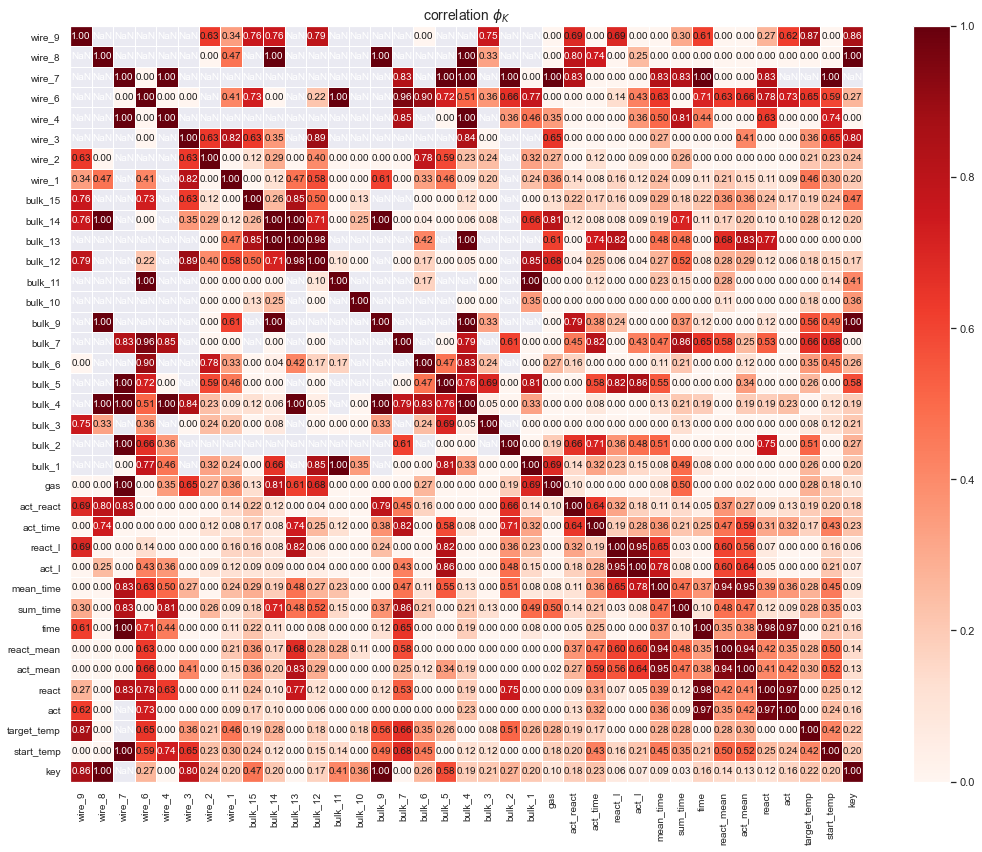

In [69]:
phik_overview = data.phik_matrix()
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Reds", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1, 
                        figsize=(15, 12))
plt.tight_layout()

Слегка неожиданная картина для меня в части корреляции, точнее, отсутствия корреляции между таргетом и стартовой и конечной мощностями. При этом есть корреляция с аггрегированной мощностью. В целом наибольшая корреляция у таргета со стартовой температурой, с аггрегированными мощностями, с суммарным и средним временем нагрева и с отдельными добавами (из-за некоторых партий где были эксклюзивно использованы некоторые добавки). Признаки с нулевой корреляций (неаггрегированные мощности, неаггрегированное время) пойдут в дроп.

У меня пока только 1 вопрос:

Все ли я правильно делаю, мне немного тревожно из-за слабых корреляций у таргета?
Заранее спасибо за ответ.

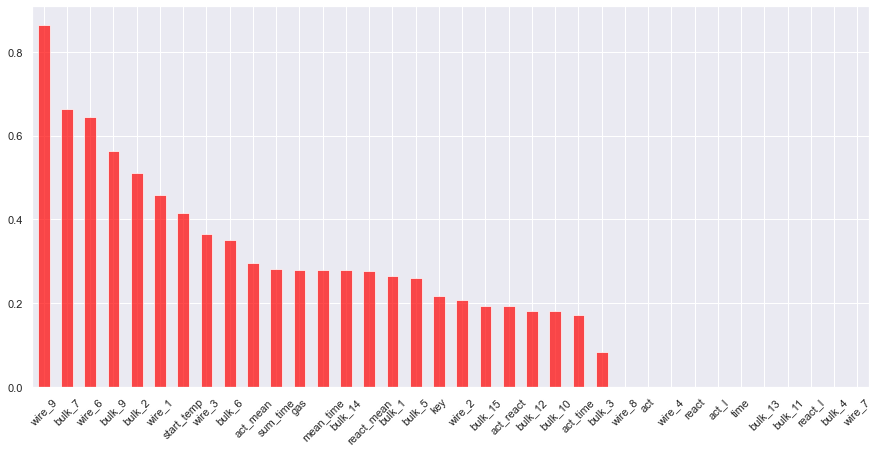

In [70]:
phik_overview['target_temp'].sort_values(ascending=False)[1:].plot(kind='bar',
                                                                   rot=45,
                                                                   color='red',
                                                                   alpha=0.7);

Отсортировал данные по степени корреляции с таргетом. Удалю фичи, которые имеют слишком высокую корреляцию с таргетом (9 проволока), которые имеют сильную корреляцию с партией - значит это были экспериментальные добавки, которые явно не повлияют на модель в лучшую сторону, также удалю сами номера партий, и признаки которые имеют сильную корреляцию друг с другом.

In [71]:
data = data.drop([
    'key', 'wire_9', 'key', 'act', 'react', 'wire_8', 'bulk_9', 'wire_7',
    'react_l'
],
                 axis=1)

## Подготовка данных и обучение модели

### Разделение выборок

In [72]:
data.fillna(0, inplace=True)

Пропуски заполню нулями, обязательно это надо будет указать заказчику.

In [73]:
data

,start_temp,target_temp,act_mean,react_mean,time,sum_time,mean_time,act_l,act_time,act_react,...,bulk_12,bulk_13,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6
0,1571.0,1613.0,0.975629,0.636648,228,1098,219.600000,0.692755,0.004443,1.532447,...,206.0,0.0,150.0,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0
1,1581.0,1602.0,0.763150,0.499528,137,811,202.750000,0.827743,0.003764,1.527741,...,206.0,0.0,149.0,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0
2,1596.0,1599.0,0.505176,0.319815,280,655,131.000000,0.250280,0.003856,1.579589,...,205.0,0.0,152.0,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0
3,1601.0,1625.0,0.802313,0.515074,207,741,185.250000,1.220955,0.004331,1.557663,...,207.0,0.0,153.0,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0
4,1576.0,1602.0,0.836793,0.563161,251,869,217.250000,0.267457,0.003852,1.485887,...,203.0,0.0,151.0,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2320,1570.0,1591.0,0.802673,0.590194,207,723,180.750000,0.435236,0.004441,1.360014,...,256.0,0.0,129.0,223.0,89.150879,0.00000,0.0,0.0,0.0,0.0
2321,1554.0,1591.0,0.700511,0.468364,117,940,156.666667,1.049800,0.004471,1.495654,...,256.0,0.0,129.0,226.0,114.179527,0.00000,0.0,0.0,0.0,0.0
2322,1571.0,1589.0,0.737460,0.617090,156,569,189.666667,0.796857,0.003888,1.195061,...,230.0,0.0,124.0,226.0,94.086723,9.04800,0.0,0.0,0.0,0.0
2323,1591.0,1594.0,0.681745,0.471086,256,750,150.000000,0.180213,0.004545,1.447179,...,206.0,0.0,129.0,207.0,118.110717,0.00000,0.0,0.0,0.0,0.0


In [74]:
x = data.drop(['target_temp'], axis=1)
y = data['target_temp']

In [75]:
x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size=0.25,
                                                    random_state=RS)

In [76]:
print(x_train.shape, '\n')
print(x_test.shape)

(1743, 30) 

(582, 30)


Данные разделены, все хорошо, можно готовить пайплайн

### Сборка пайплайна

In [77]:
min_max_col = list(
    filter(lambda s: 'wire' in s or 'bulk' in s, x_train.columns.to_list()))
stan_col = list(
    filter(lambda s: 'wire' not in s and 'bulk' not in s, x_train.columns.to_list()))

Разделю колонку по виду распределения данных, чтобы применить правильный скейлер (для линейной регрессии)

In [78]:
len(x_train.columns.to_list())

30

In [79]:
feature_selector = SelectKBest(mutual_info_regression)
feature_selector.fit_transform(x, y)
feature_selector.get_feature_names_out()

array(['start_temp', 'react_mean', 'sum_time', 'mean_time', 'bulk_4',
       'bulk_6', 'bulk_12', 'bulk_14', 'bulk_15', 'wire_1'], dtype=object)

Беглый взгляд на слектор фичей, все ок, все работает

In [80]:
columns_pipeline = ColumnTransformer(
    [('min_max_col', MinMaxScaler(), min_max_col), 
    ('standart_col', StandardScaler(), stan_col)])
columns_pipeline

ColumnTransformer(transformers=[('min_max_col', MinMaxScaler(),
                                 ['bulk_1', 'bulk_2', 'bulk_3', 'bulk_4',
                                  'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8',
                                  'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13',
                                  'bulk_14', 'bulk_15', 'wire_1', 'wire_2',
                                  'wire_3', 'wire_4', 'wire_5', 'wire_6']),
                                ('standart_col', StandardScaler(),
                                 ['start_temp', 'act_mean', 'react_mean',
                                  'time', 'sum_time', 'mean_time', 'act_l',
                                  'act_time', 'act_react', 'gas'])])

In [81]:
pipeline = make_pipeline(columns_pipeline, DropDuplicateFeatures())
pipeline.steps.append(('feature_select', SelectKBest(mutual_info_regression)))
pipeline.steps.append(('estimator', DummyRegressor(strategy='median')))
pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('min_max_col', MinMaxScaler(),
                                                  ['bulk_1', 'bulk_2', 'bulk_3',
                                                   'bulk_4', 'bulk_5', 'bulk_6',
                                                   'bulk_7', 'bulk_8',
                                                   'bulk_10', 'bulk_11',
                                                   'bulk_12', 'bulk_13',
                                                   'bulk_14', 'bulk_15',
                                                   'wire_1', 'wire_2', 'wire_3',
                                                   'wire_4', 'wire_5',
                                                   'wire_6']),
                                                 ('standart_col',
                                                  StandardScaler(),
                                                  ['start_temp', 'act_mean',
                                                   'react_mean', 'time',
                                                   'sum_time', 'mean_time',
                                                   'act_l', 'act_time',
                                                   'act_react', 'gas'])])),
                ('dropduplicatefeatures', DropDuplicateFeatures()),
                ('feature_select',
                 SelectKBest(score_func=<function mutual_info_regression at 0x0000022B05D23E50>)),
                ('estimator', DummyRegressor(strategy='median'))])

In [82]:
pipeline.fit(x_train, y_train)
mean_absolute_error(y_train, pipeline.predict(x_train))

8.156052782558806

Пайплан готов: трансформтаор колонок для линейной регрессии, на всякий дроп дубликатов, далее подбор количества фичей и оценщик - пока даммич, который выдал уверенные 8 градусов ошибки, не плохо.

### Обучение модели в Гридесерче

In [83]:
grid_params = [{
    'estimator': [LinearRegression()],
    'feature_select__k': [10, 15, 18, 20, 25, 27, 29, 31, all]
}, {
    'estimator': [LGBMRegressor(random_state=RS, n_jobs=-1)],
    'estimator__n_estimators': [50, 70, 100, 150, 200],
    'estimator__learning_rate':[0.3, 0.1, 0.05, 0.01],
    'feature_select__k': [10, 15, 18, 20, 25, 27, 29, 31, all],
    'columntransformer':['passthrough']
}]

Накинул параметров для перебора гридсерчу, в том числе количество фичей. Для бустинга отключил трансформацию колонок, она ему не нужна.

In [84]:
grid = GridSearchCV(pipeline,
                    grid_params,
                    cv=4, # 4 фолда, поскольку данных довольно мало
                    verbose=1,
                    scoring='neg_mean_absolute_error',
                    n_jobs=-1)

In [85]:
%%time

grid.fit(x_train, y_train)
grid.best_estimator_

Fitting 4 folds for each of 189 candidates, totalling 756 fits
CPU times: total: 2.94 s
Wall time: 13.3 s


Pipeline(steps=[('columntransformer', 'passthrough'),
                ('dropduplicatefeatures', DropDuplicateFeatures()),
                ('feature_select',
                 SelectKBest(k=27,
                             score_func=<function mutual_info_regression at 0x0000022B05D23E50>)),
                ('estimator',
                 LGBMRegressor(learning_rate=0.05, random_state=270323))])

In [86]:
print(grid.best_params_, '\n')
print(grid.best_score_)

{'columntransformer': 'passthrough', 'estimator': LGBMRegressor(learning_rate=0.05, random_state=270323), 'estimator__learning_rate': 0.05, 'estimator__n_estimators': 100, 'feature_select__k': 27} 

-6.079948126076139


Победил бустинг (ожидаемо), на кроссвалидации ошибка в 6 градусов удовлетворяет требованиям заказчика.

### Анализ признаков, оказавших наибольшее влияние на результат

In [87]:
important_f = pd.DataFrame()
important_f['name'] = list(grid.best_estimator_.steps[-2][-1].get_feature_names_out())
important_f['importance'] = grid.best_estimator_.steps[-1][-1].feature_importances_

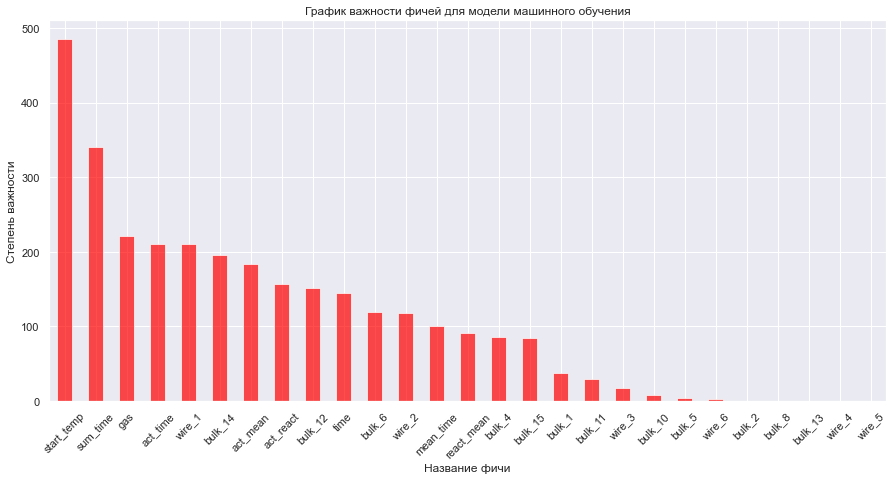

In [88]:
important_f.sort_values(by='importance',
                        ascending=False).reset_index(drop=True).plot(
                            kind='bar',
                            x='name',
                            rot=45,
                            color='red',
                            alpha=0.7).get_legend().remove()
plt.title('График важности фичей для модели машинного обучения')
plt.xlabel('Название фичи')
plt.ylabel('Степень важности');

Теперь можно воспользоваться встроенной функцией бустинга и взглянуть на важность фичей для модели. В целом все логично, влияют больше всего стартовая температура, суммарное время работы электродов, объем газа, отношение средней мощности к среднему времени, а также добавки

### Испытаниe модели на тестовой выборке

In [89]:
mean_absolute_error(y_test, grid.predict(x_test))

5.521498023815768

Тест определенно порадовал, удалось выйти из 6 градусов и дойти до 5.5, требования заказчика собдлюдены.

## Отчет

Все пункты намеченного плана удалось выполнить, трудностей при работе установлено не было. 

Ключевые моменты в решении задачи: правильный анализ данных и подбор + синтез признаков для обучения модели. И обучение модели с использованием кросс-валидации для подбора оптимальных гиперпараметров.

Наибольшее влияние на целевое значение (финальную температуру) оказывает стартовая температура, суммарное время нагрева, определенные виды легирующих компонентов, а также объем газа.
В рамках предобработки были выброшены партии с температурой ниже 1500 градусов, без целевой температуры и с отрицательными значениями мощности. Были созданы синтетические признаки: время нагрева, среднее время по цмклу нагрева, относшение мощности ко времени и др. 

Итоговая модель - модель градиентного бустинга LGBMRegressor. Были определены гиперпараметры: learning_rate: 0.05, n_estimators: 100. Также в гридсерче было подобрано оптимальное количество парметров, которое составило 27. Размер ошибки на тестовой выборке составил 5.5.